In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
def e_step(X, mu, var, pi):
    """
    Perform the E-step of the EM algorithm.
    Inputs:
        X: (N, 2) array representing the data points
        mu: (3, 2) array representing the means of the three Gaussian distributions
        var: (3, 2, 2) array representing the covariance matrices of the three Gaussian distributions
        pi: (3,) array representing the mixing coefficients of the three Gaussian distributions
    Returns:
        R: (3, N) array representing the probability distribution of each data point across the three Gaussian distributions
    """
    N = X.shape[0]
    K = mu.shape[0]
    R = np.zeros((K, N))

    for k in range(K):
        cov_inv = np.linalg.inv(var[k])
        X_mu = X - mu[k]
        exponent = np.sum(X_mu @ cov_inv * X_mu, axis=1)
        coef = 1 / np.sqrt((2 * np.pi) ** 2 * np.linalg.det(var[k]))
        R[k] = pi[k] * coef * np.exp(-0.5 * exponent)


    # Normalize the probabilities
    R /= np.sum(R, axis=0)
    # # Compute the argmax of the responsibilities to assign each data point to a distribution
    # argmax_R = np.argmax(R, axis=0)
    #
    # # Convert argmax to binary matrix R
    # R = np.zeros((K, N))
    # for i in range(len(argmax_R)):
    #     R[argmax_R[i], i] = 1

    return R



In [4]:
def m_step(X, R):
    """
    Perform the M-step of the EM algorithm.
    Inputs:
        X: (N, 2) array representing the data points
        R: (3, N) array representing the probability distribution of each data point across the three Gaussian distributions
    Returns:
        mu_new: (3, 2) array representing the updated means of the three Gaussian distributions
        var_new: (3, 2, 2) array representing the updated covariance matrices of the three Gaussian distributions
        pi_new: (3,) array representing the updated mixing coefficients of the three Gaussian distributions
    """
    N = X.shape[0]
    K = R.shape[0]

    # Update the mixing coefficients
    pi_new = np.sum(R, axis=1) / N

    # Update the means
    mu_new = np.zeros((K, 2))
    for k in range(K):
        mu_new[k] = np.sum(R[k].reshape(-1, 1) * X, axis=0) / np.sum(R[k])

    # Update the covariances
    var_new = np.zeros((K, 2, 2))
    for k in range(K):
        X_mu = X - mu_new[k]
        R_diag = np.diag(R[k])
        var_new[k] = (X_mu.T @ R_diag @ X_mu) / np.sum(R[k]) + 1e-6 * np.eye(2)

    return mu_new, var_new, pi_new

In [5]:
def compute_log_likelihood(X, mu, var, pi):
    """
    Compute the log likelihood of the data given the current parameters of the mixture model.
    Inputs:
        X: (N, 2) array representing the data points
        mu: (3, 2) array representing the means of the three Gaussian distributions
        var: (3, 2, 2) array representing the covariance matrices of the three Gaussian distributions
        pi: (3,) array representing the mixing coefficients of the three Gaussian distributions
    Returns:
        ll: float representing the log likelihood of the data
    """
    N = X.shape[0]
    K = mu.shape[0]
    ll = 0

    for n in range(N):
        p_x = 0
        for k in range(K):
            cov_inv = np.linalg.inv(var[k])
            X_mu = X[n] - mu[k]
            exponent = X_mu @ cov_inv @ X_mu.T
            coef = 1 / np.sqrt((2 * np.pi) ** 2 * np.linalg.det(var[k]))
            p_x += pi[k] * coef * np.exp(-0.5 * exponent)
        ll += np.log(p_x)

    return ll


In [77]:
def run_em(X, mu, var, pi, max_iter=200, tol=1e-4):
    """
    Run the EM algorithm to estimate the parameters of the Gaussian mixture model.
    Inputs:
        X: (N, 2) array representing the data points
        mu: (3, 2) array representing the initial means of the three Gaussian distributions
        var: (3, 2, 2) array representing the initial covariance matrices of the three Gaussian distributions
        pi: (3,) array representing the initial mixing coefficients of the three Gaussian distributions
        max_iter: int representing the maximum number of iterations to run the algorithm
        tol: float representing the tolerance level for convergence
    Returns:
        mu: (3, 2) array representing the estimated means of the three Gaussian distributions
        var: (3, 2, 2) array representing the estimated covariance matrices of the three Gaussian distributions
        pi: (3,) array representing the estimated mixing coefficients of the three Gaussian distributions
        log_likelihoods: list of log-likelihoods at each iteration
    """
    log_likelihoods = []
    for i in range(max_iter):
        # E-step
        R = e_step(X, mu, var, pi)

        # M-step
        mu_new, var_new, pi_new = m_step(X, R)

        # Compute log-likelihood
        log_likelihood = compute_log_likelihood(X, mu_new, var_new, pi_new)

        # Check for convergence
        if i > 0 and abs(log_likelihood - log_likelihoods[-1]) < tol:
            break

        # Update parameters
        mu = mu_new
        var = var_new
        pi = pi_new

        # Save log-likelihood
        log_likelihoods.append(log_likelihood)

    # Plot the distributions
    labels = np.argmax(R, axis=0)
    colors = ['red', 'green', 'blue']
    distributions = ['background', 'brain', 'tumor']
    for j in range(3):
        plt.scatter(X[labels == j, 0], X[labels == j, 1], c=colors[j], label=distributions[j])
        plt.scatter(mu[j, 0], mu[j, 1], marker='x', s=100, c='black')
    plt.title('Estimated Result')
    plt.legend()
    plt.show()

    return mu, var, pi, R, log_likelihoods


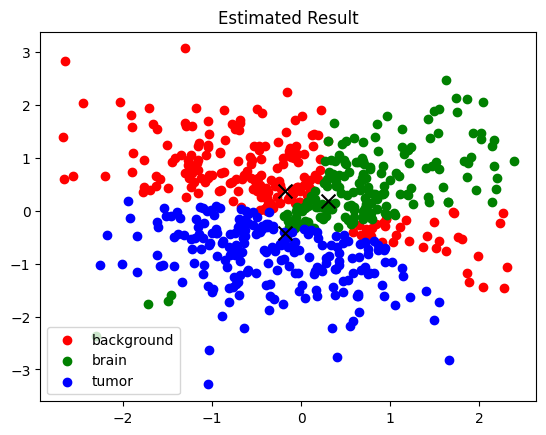

Actual means:
 [[-0.1030724   0.00457454]
 [ 0.13796774  0.01442499]
 [-0.11151422  0.11454718]]

Actual covariances:
 [[[ 0.97358273 -0.0472312 ]
  [-0.0472312   0.93918291]]

 [[ 1.02775355  0.4604333 ]
  [ 0.4604333   0.94546824]]

 [[ 0.8731411  -0.44841   ]
  [-0.44841     0.90568068]]]
Updated means:
 [[-0.18297544  0.37370929]
 [ 0.30538457  0.18622105]
 [-0.17527515 -0.41755674]]

Updated covariances:
 [[[ 0.97956797 -0.44932742]
  [-0.44932742  0.77478385]]

 [[ 0.93670537  0.5326999 ]
  [ 0.5326999   0.78390556]]

 [[ 0.83270305 -0.14718402]
  [-0.14718402  0.87459445]]]

Updated weights:
 [0.34207728 0.31700102 0.34092169]
Posterior:
 [[0.37728447 0.42512799 0.50823837 ... 0.04724789 0.84215274 0.13890211]
 [0.35835915 0.32539055 0.30238975 ... 0.13980689 0.00457359 0.0697117 ]
 [0.26435638 0.24948146 0.18937189 ... 0.81294522 0.15327367 0.79138619]]


In [86]:
data = np.loadtxt('Image2.csv', delimiter=',')
data_adjusted = np.zeros((600,2))
for i in range(600):
    data_adjusted[i, 0] = data[i+1 , 1]
    data_adjusted[i, 1] = data[i+1, 2]


# Define initial parameters
mu = np.random.rand(3, 2)
cov = np.array([[[1, 0], [0, 1]], [[1, 0], [0, 1]], [[1, 0], [0, 1]]])
weights = np.array([1/3, 1/3, 1/3])

# # Run EM algorithm for one iteration
# R = e_step(data_adjusted , mu, cov, weights)
# mu_new, cov_new, weights_new = m_step(data_adjusted , R)
# print(R)

estimated_means, estimated_covariances, estimated_weights, assignments, log_likelihoods = run_em(data_adjusted , mu, cov, weights)

#Actual Parameters
background_mean = [np.mean(data_adjusted [:200, 0]), np.mean(data_adjusted [:200, 1])]
background_var = np.cov(data_adjusted [:200, 0] ,data_adjusted [:200, 1])

normal_mean = [np.mean(data_adjusted [200:400, 0]), np.mean(data_adjusted [200:400, 1])]
normal_var = np.cov(data_adjusted [200:400, 0],data_adjusted [200:400, 1])

tumor_mean = [np.mean(data_adjusted [400:, 0]), np.mean(data_adjusted [400:, 1])]
tumor_var = np.cov(data_adjusted [400:, 0], data_adjusted [400:, 1])

actual_mean = np.array([background_mean, normal_mean, tumor_mean])
actual_var = np.array([background_var, normal_var, tumor_var])


# Print updated parameters
print("Actual means:\n", actual_mean)
print("\nActual covariances:\n", actual_var)
print("Updated means:\n", estimated_means)
print("\nUpdated covariances:\n", estimated_covariances)
print("\nUpdated weights:\n", estimated_weights)
print('Posterior:\n', assignments)

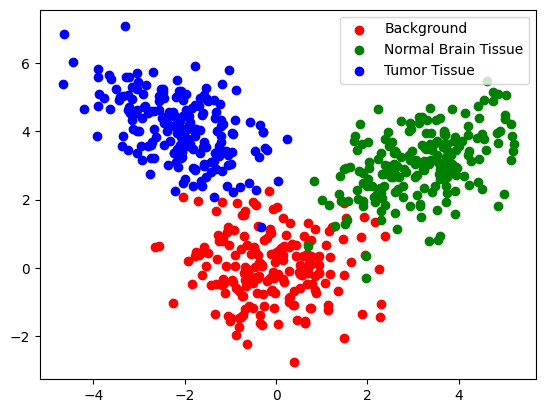

In [16]:

#Simulation Question 1
# Load the data from Image1.csv or Image2.csv
data1 = np.loadtxt('Image1.csv', delimiter=',')

# plot the data points with three different colors
plt.scatter(data1[1:201, 1], data1[1:201, 2], color='red', label='Background')
plt.scatter(data1[201:401, 1], data1[201:401, 2], color='green', label='Normal Brain Tissue')
plt.scatter(data1[401:, 1], data1[401:, 2], color='blue', label='Tumor Tissue')
plt.legend()
plt.show()

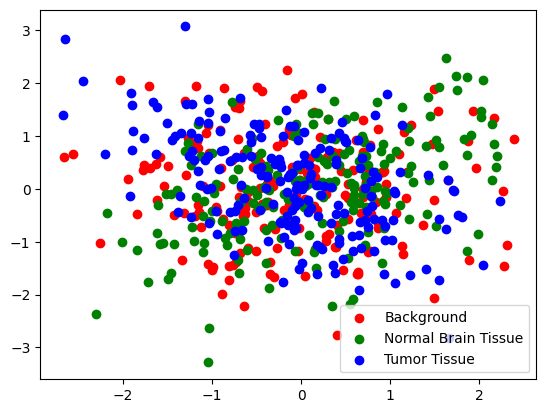

In [18]:
#Simulation Question 1
# Load the data from Image1.csv or Image2.csv
data2 = np.loadtxt('Image2.csv', delimiter=',')

# plot the data points with three different colors
plt.scatter(data2[1:201, 1], data2[1:201, 2], color='red', label='Background')
plt.scatter(data2[201:401, 1], data2[201:401, 2], color='green', label='Normal Brain Tissue')
plt.scatter(data2[401:, 1], data2[401:, 2], color='blue', label='Tumor Tissue')
plt.legend()
plt.show()

In [87]:
#percentage between datas
asignr=np.argmax(assignments,axis=0)
print(asignr)
es_point=np.zeros((3,3))
for i in range (3):
    for j in range(3):
        for k in range(200):
            if asignr[j*200+k]==i:
                es_point[i,j]+=1
print(es_point)
max_point=(np.amax(es_point,axis=0)/200)*100
print(max_point)

[0 0 0 1 1 0 2 0 2 0 1 1 1 2 0 1 2 2 0 2 0 2 0 2 0 0 2 2 2 2 0 2 1 2 2 2 0
 0 2 1 0 0 0 0 1 0 0 0 0 0 2 1 1 0 0 0 1 2 0 2 0 1 0 2 0 1 2 0 0 1 0 2 0 2
 2 2 2 0 1 0 2 1 1 2 0 2 0 2 2 2 2 0 0 2 1 1 1 2 1 2 2 1 1 0 2 0 0 2 0 2 1
 2 2 0 0 2 1 2 1 2 1 2 2 1 1 2 0 2 2 2 1 0 2 1 2 1 0 0 0 1 0 1 2 0 0 0 0 0
 2 0 2 1 0 2 0 1 1 2 2 2 0 0 2 2 0 0 0 0 2 2 0 1 2 0 2 2 0 1 1 0 2 2 2 0 0
 2 0 0 2 2 2 1 1 2 2 1 1 2 1 0 2 1 1 1 2 2 2 2 1 1 2 1 0 2 1 2 2 0 0 2 2 1
 1 2 0 0 1 1 1 0 1 1 1 1 2 2 2 2 1 2 2 0 1 2 1 1 1 2 2 1 1 1 2 1 1 2 0 0 1
 2 2 1 1 2 1 1 1 2 0 1 2 2 1 2 0 1 1 1 2 1 2 0 2 0 2 1 0 1 1 1 0 0 2 0 2 1
 1 1 1 1 2 1 1 2 0 2 2 2 1 0 0 1 1 2 0 1 2 0 2 1 2 0 2 2 0 2 1 1 2 1 0 1 0
 1 0 1 2 0 2 0 2 0 0 1 0 1 0 1 0 0 2 2 1 1 2 1 2 1 2 1 0 2 1 1 2 2 0 1 1 1
 0 1 2 0 0 2 2 1 2 2 1 1 1 1 0 1 1 2 2 2 2 1 1 0 1 2 1 2 1 2 0 2 1 0 1 1 2
 1 2 0 1 0 0 1 1 2 0 0 0 0 0 2 2 2 2 2 2 0 1 2 1 0 0 2 2 2 2 0 1 2 0 2 0 0
 0 2 0 2 0 1 2 0 2 2 0 1 0 0 0 1 2 1 0 2 2 0 2 1 1 1 1 0 2 0 0 0 0 1 0 2 1
 0 1 1 0 2 1 0 1 0 1 0 0 